In [7]:
#Can ESG be used to predict the returns of results? That's the question that will be attempted to answer using:
# - Mutual fund/ETF data
# - Analysis of ESG data


In [3]:
#Import packages
import numpy as np
import pandas as pd 
import seaborn as sns
import keras
from keras import layers

In [5]:
#configure seabron for a dark background
sns.set(style="darkgrid")

In [9]:
#load in the datasets with columns relevant to the topic, which includes the ESG columns
cols = ['isin','fund_trailing_return_ytd', 'social_score', 'environmental_score', 'governance_score', 'sustainability_score']
etf = pd.read_csv("Morningstar - European ETFs.csv",usecols=cols).dropna()
mf = pd.read_csv("Morningstar - European Mutual Funds.csv",usecols=cols).dropna()

In [11]:
#glimpse at ETF dataframe
etf.head()

,isin,environmental_score,social_score,governance_score,sustainability_score,fund_trailing_return_ytd
0,CH0008899764,3.37,10.65,8.42,22.44,8.69
1,SE0000693293,3.79,8.61,8.12,20.52,17.61
2,DE000A0H08N1,4.45,7.41,6.97,18.91,8.90
4,IE0032523478,4.45,10.25,8.94,23.95,8.39
5,IE0032895942,3.76,11.56,8.58,24.64,9.26


In [13]:
#glimpse at Mutual Fund dataframe
mf.head()

,isin,environmental_score,social_score,governance_score,sustainability_score,fund_trailing_return_ytd
1,LU0757425763,2.30,10.48,8.46,21.24,16.59
2,LU0011818076,5.89,10.13,9.25,25.27,-3.20
3,LU0152882725,4.19,10.31,7.75,22.33,9.02
4,LU0114999294,4.19,10.31,7.75,22.33,8.73
5,LU0119620416,2.71,10.26,7.42,20.38,10.56


In [17]:
#Something that stands out is that the sustainability score looks like it's the sum of the 3 ESG components.
#Let's see if that's true
esg_cols = ['social_score', 'environmental_score', 'governance_score']
esg_sum = mf[esg_cols].sum(axis=1)
df_esg_sum = esg_sum.to_frame('esg_sum')
df = mf.join(df_esg_sum)

df[['isin', 'esg_sum','sustainability_score']].head()

,isin,esg_sum,sustainability_score
1,LU0757425763,21.24,21.24
2,LU0011818076,25.27,25.27
3,LU0152882725,22.25,22.33
4,LU0114999294,22.25,22.33
5,LU0119620416,20.39,20.38


In [25]:
#While its close, its not an exact match
#Checking some descriptive stats below out of curiosity

In [21]:
etf.describe()

,environmental_score,social_score,governance_score,sustainability_score,fund_trailing_return_ytd
count,5907.000000,5907.000000,5907.000000,5907.000000,5907.000000
mean,5.207669,9.807368,8.082131,23.742045,3.831908
std,3.213267,2.449350,2.073931,4.019120,14.122744
min,0.070000,2.960000,3.130000,9.720000,-92.830000
25%,3.830000,8.915000,7.390000,21.770000,-1.675000
50%,4.600000,10.020000,7.900000,23.200000,5.820000
75%,5.730000,10.760000,8.810000,25.250000,10.615000
max,62.700000,63.680000,59.070000,55.910000,69.040000


In [23]:
mf.describe()

,environmental_score,social_score,governance_score,sustainability_score,fund_trailing_return_ytd
count,30371.00000,30371.000000,30371.000000,30371.000000,30371.000000
mean,4.86192,9.566749,7.865254,23.751325,6.797172
std,3.94983,3.421844,3.344090,3.522166,14.026196
min,0.20000,2.760000,2.580000,8.830000,-55.820000
25%,3.74000,8.650000,7.060000,21.840000,-0.855000
50%,4.41000,9.520000,7.660000,23.320000,6.040000
75%,5.18000,10.230000,8.250000,25.030000,13.230000
max,66.47000,65.000000,62.200000,60.570000,104.670000


In [29]:
#Correlation check: see if there's any ovbious correlation with the ESG data and returns
mf_n = mf.select_dtypes(include=['number'])
etf_n = etf.select_dtypes(include=['number'])
mf_n.corr()
etf_n.corr()

,environmental_score,social_score,governance_score,sustainability_score,fund_trailing_return_ytd
environmental_score,1.000000,0.441917,0.394837,0.699947,-0.284219
social_score,0.441917,1.000000,0.801602,0.594261,0.079225
governance_score,0.394837,0.801602,1.000000,0.442734,-0.024173
sustainability_score,0.699947,0.594261,0.442734,1.000000,-0.150258
fund_trailing_return_ytd,-0.284219,0.079225,-0.024173,-0.150258,1.000000


In [31]:
#There aren't any strong correlations between returns and ESG scores, but a few moderately strong numbers when looking at 
#the ESG scores measured up against themselves

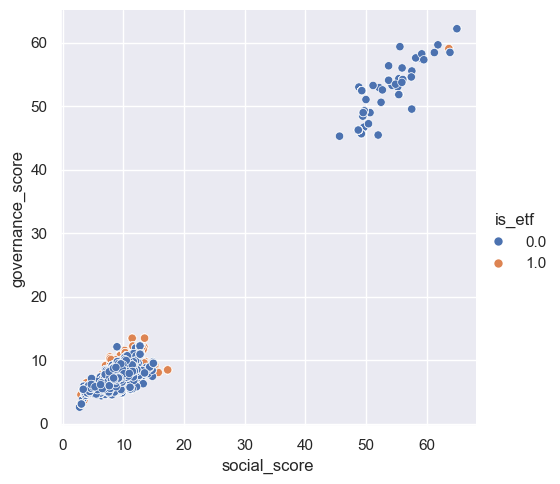

In [39]:
#Plotting correlations with a variable to differentiate ETFs from MFs
etf_flag = pd.DataFrame(np.ones(len(etf_n)), columns=['is_etf'], index=etf_n.index)

df = pd.concat([etf_n,etf_flag],axis=1) 
etf_flag_fund = pd.DataFrame(np.zeros(len(mf_n)), columns=['is_etf'], index=mf_n.index)
df2 =  pd.concat([mf_n, etf_flag_fund], axis=1) 

return_esg_merged = pd.concat([df,df2],ignore_index=True)

sns.relplot(x='social_score', y='governance_score', hue='is_etf', data=return_esg_merged)

In [41]:
#Regression model for MFs
np_data = np.array(mf_n)
x = np.float32(np_data[:,1:-1])
y = np.float32(np_data[:,-1])

In [43]:
#Using optimal guessing as a benchmark
optimal_guessing = np.mean(y)
optimal_guessing_mean_accuracy = np.mean(abs(y-optimal_guessing))
print("Optimal guessing mean accuracy: ", optimal_guessing_mean_accuracy)

Optimal guessing mean accuracy:  9.976747


In [45]:
#Building the neural network
model = keras.Sequential(
    [
        layers.Dense(100, activation="relu", name="layer1"),
        layers.Dense(100, activation="relu", name="layer2"),
        layers.Dense(1, name="layer3")
    ]
)
model.compile(loss="mse", optimizer="adam", metrics=["mae"])

In [47]:
#Fitting the model
hist = model.fit(x,y, validation_split=0.1, epochs=150)

Epoch 1/150
855/855 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 200.2138 - mae: 10.0673 - val_loss: 204.9157 - val_mae: 10.5994
Epoch 2/150
855/855 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 189.8989 - mae: 9.8039 - val_loss: 200.7842 - val_mae: 10.4077
Epoch 3/150
855/855 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 189.0174 - mae: 9.7844 - val_loss: 199.4924 - val_mae: 10.3558
Epoch 4/150
855/855 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 189.7310 - mae: 9.7511 - val_loss: 212.8896 - val_mae: 11.0500
Epoch 5/150
855/855 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 192.3347 - mae: 9.8178 - val_loss: 196.2038 - val_mae: 10.0884
Epoch 6/150
855/855 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 189.4679 - mae: 9.7273 - val_loss: 189.7413 - val_mae: 9.8858
Epoch 7/150
855/855 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 180.0955 - mae: 9.5165 - val_loss: 188.9174 - val_mae: 9.8338
Epoch 8/150
855/855 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 179.6862 - mae: 9.4322 - val_loss: 193.0377 - val_mae: 10.1936
Epoch 9/1

<Axes: >

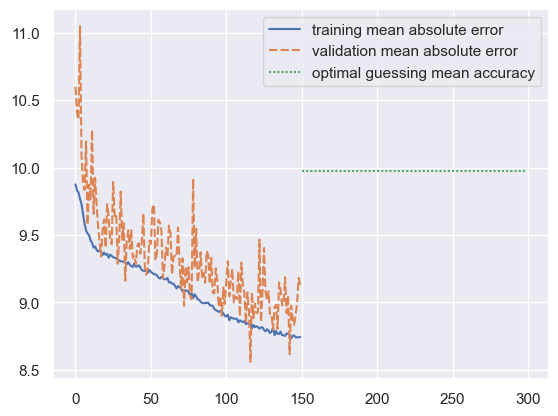

In [51]:
#Plot the results
df_hist = pd.DataFrame.from_dict(hist.history)
columns_map = {'mae' : 'training mean absolute error', 'val_mae' : 'validation mean absolute error'}
df_hist.rename(columns = columns_map, inplace=True)
df_optimal_guessing = pd.DataFrame(np.ones(len(df_hist))*optimal_guessing_mean_accuracy, columns=['optimal guessing mean accuracy'])
df_plot = pd.concat([df_hist[columns_map.values()], df_optimal_guessing], ignore_index=True)
sns.lineplot(data=df_plot)

In [53]:
#Regressor using ETFs
np_data = np.array(etf_n)
x = np.float32(np_data[:,1:-1])
y = np.float32(np_data[:,-1])

optimal_guessing = np.mean(y)
optimal_guessing_mean_accuracy = np.mean(abs(y-optimal_guessing))
print("Optimal guessing mean accuracy: ", optimal_guessing_mean_accuracy)

Optimal guessing mean accuracy:  9.902584


In [55]:
hist2 = model.fit(x,y, validation_split=0.1, epochs=150)

Epoch 1/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 153.2816 - mae: 8.3884 - val_loss: 182.4705 - val_mae: 8.3696
Epoch 2/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 119.1046 - mae: 7.3428 - val_loss: 173.1431 - val_mae: 8.1870
Epoch 3/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 119.0783 - mae: 7.3815 - val_loss: 169.8372 - val_mae: 8.2215
Epoch 4/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 121.0661 - mae: 7.1411 - val_loss: 180.0816 - val_mae: 8.1707
Epoch 5/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 116.6452 - mae: 7.2668 - val_loss: 164.9890 - val_mae: 7.9042
Epoch 6/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 111.3000 - mae: 7.1384 - val_loss: 165.6944 - val_mae: 7.9846
Epoch 7/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 106.8149 - mae: 6.8961 - val_loss: 172.6307 - val_mae: 8.2894
Epoch 8/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 110.4280 - mae: 6.9286 - val_loss: 163.9717 - val_mae: 7.8108
Epoch 9/150
167/

<Axes: >

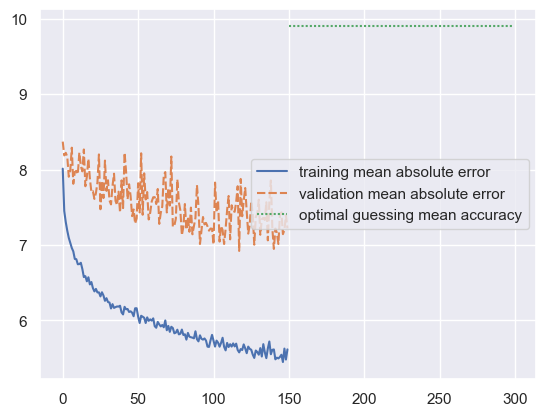

In [57]:
df_hist = pd.DataFrame.from_dict(hist2.history)
columns_map = {'mae' : 'training mean absolute error', 'val_mae' : 'validation mean absolute error'}
df_hist.rename(columns = columns_map, inplace=True)
df_optimal_guessing = pd.DataFrame(np.ones(len(df_hist))*optimal_guessing_mean_accuracy, columns=['optimal guessing mean accuracy'])
df_plot = pd.concat([df_hist[columns_map.values()], df_optimal_guessing], ignore_index=True)
sns.lineplot(data=df_plot)

In [59]:
#Looks like we might have some overfitting above, which differentiates itself from the first one.

In [63]:
#Combining the funds
np_data_combined = np.array(pd.concat([mf_n, etf_n], ignore_index=True))
x_combined = np.float32(np_data_combined[:,1:-1])
y_combined = np.float32(np_data_combined[:,-1])
optimal_guessing_combined = np.mean(y_combined)
optimal_guessing_mean_accuracy_combined = np.mean(abs(y_combined-optimal_guessing_combined))
print("Optimal guessing mean accuracy: ", optimal_guessing_mean_accuracy_combined)
model_combined = keras.Sequential(
    [
        layers.Dense(100, activation="relu", name="layer1"),
        layers.Dense(100, activation="relu", name="layer2"),
        layers.Dense(1, name="layer3")
    ]
)
model_combined.compile(loss="mse", optimizer="adam", metrics=["mae"])

Optimal guessing mean accuracy:  9.9313965


In [67]:
hist_combined = model_combined.fit(x_combined,y_combined, validation_split=0.1, epochs=150)

Epoch 1/150
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 202.0690 - mae: 10.0245 - val_loss: 187.8305 - val_mae: 9.3021
Epoch 2/150
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 196.7730 - mae: 9.9157 - val_loss: 180.6758 - val_mae: 9.0203
Epoch 3/150
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 194.3663 - mae: 9.8649 - val_loss: 179.1468 - val_mae: 8.9552
Epoch 4/150
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 192.0313 - mae: 9.7618 - val_loss: 179.8569 - val_mae: 8.9659
Epoch 5/150
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 196.8795 - mae: 9.8518 - val_loss: 174.6199 - val_mae: 8.7683
Epoch 6/150
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 190.7690 - mae: 9.7106 - val_loss: 168.5447 - val_mae: 8.5711
Epoch 7/150
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 193.3884 - mae: 9.7050 - val_loss: 172.1222 - val_mae: 8.6739
Epoch 8/150
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 185.1352 - mae: 9.4401 - val_loss: 174.6198 - val_mae: 8.9182

<Axes: >

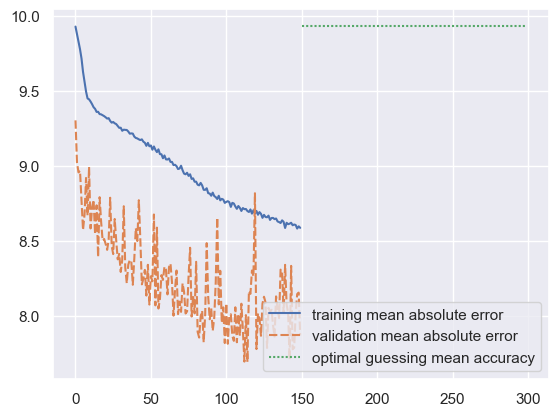

In [77]:
df_hist_combined = pd.DataFrame.from_dict(hist_combined.history)
columns_map = {'mae' : 'training mean absolute error', 'val_mae' : 'validation mean absolute error'}
df_hist_combined.rename(columns = columns_map, inplace=True)
df_optimal_guessing_combined = pd.DataFrame(np.ones(len(df_hist_combined))*optimal_guessing_mean_accuracy_combined, columns=['optimal guessing mean accuracy'])
df_plot_combined = pd.concat([df_hist_combined[columns_map.values()],df_optimal_guessing_combined],ignore_index=True)
sns.lineplot(data=df_plot_combined)

In [79]:
#Interestingly, there's an inversion here with the training and validation data

In [81]:
#Overall, there seems to be an improvement with returns with use of ESG scores, particularly with MFs, but should be
#cautious of the fact that ETFs appeared to overfit and that more variables may be necessary to better predicting results